# CLUSTERING BOOKS

In this section, I'm going to analyze the optimal amount of clusters for my data using Elbow and Silhouette methods, as well as KMeans.

Then I will add a new column to the main dataset with the corresponding cluster for each row. Once the book recommender function is built (in the following kernel), it will be easier to suggest a book from the same cluster as the one searched by the user.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster, datasets
from sklearn.cluster import KMeans

from IPython.display import Markdown, display 

import pickle

In [4]:
gr_data = pd.read_csv('./2. Clean_df/gr_data_CLEAN.csv')
gr_data = gr_data.drop(['Unnamed: 0'],axis=1)

In [5]:
gr_data.shape

(48655, 862)

In [6]:
# Check categorical columns
categorical = gr_data.select_dtypes(include=['object'])
categorical.columns

Index(['title', 'series', 'author', 'description', 'language', 'pages', 'isbn',
       'book_format', 'publisher'],
      dtype='object')

#### Recovering numerical values of 'pages' from original dataframe

As book recommender will work on numerical features, I want to recover 'pages'.

In [7]:
original_df = pd.read_csv('./1. Original_df/GoodReads.Best_Books_Ever 2.csv')
original_df['pages']

0        374
1        870
2        324
3        279
4        501
        ... 
52473      0
52474    190
52475    280
52476    507
52477    201
Name: pages, Length: 52478, dtype: object

In [8]:
# Adding column with numerical pages where 'title' matches (gr_data is shorter and no NaN)
gr_data['pages2'] = ''

for index, row in original_df.iterrows():
    title = row['title']
    pages = row['pages']
    gr_data.loc[gr_data['title'] == title, 'pages2'] = pages
#gr_data = pd.merge(gr_data, original_df[['title', 'pages']], on='title', how='left')
#merged_df.drop('title', axis=1, inplace=True)
#gr_data.rename(columns={'pages': 'pages2'}, inplace=True)

In [9]:
# Same length
len(gr_data['pages2'])

48655

In [10]:
# NaN
gr_data['pages2'].isna().sum()

114

In [11]:
# Delete rows with NaN
gr_data.dropna(subset=['pages2'], inplace=True)

In [12]:
# Type
gr_data['pages2'].dtype

dtype('O')

In [13]:
# Deleting row with str
gr_data = gr_data.drop(gr_data[gr_data['pages2'] == '1 page'].index)

# Converting to numerical
gr_data['pages2'] = gr_data['pages2'].astype(np.number)

In [14]:
gr_data['pages2'].dtype

dtype('float64')

In [187]:
gr_data.to_csv('./2. Clean_df/gr_data_FOR_CLUSTERING.csv')

### Clustering features with K-Means

#### Features (numerical data)

In [3]:
gr_data = pd.read_csv('./2. Clean_df/gr_data_FOR_CLUSTERING.csv')
gr_data = gr_data.drop(['Unnamed: 0'],axis=1)

In [4]:
features = gr_data.select_dtypes(include=np.number)
features.shape

(48540, 854)

In [5]:
X = features

#### Scaling data (without training)

In [6]:
#from sklearn.preprocessing import StandardScaler
X_prep = StandardScaler().fit_transform(X)

pd.DataFrame(X_prep,columns=X.columns).head()

,publish_year,first_publish_year,liked_perc,bbe_score,bbe_votes,log_num_ratings,5_stars_num_ratings,4_stars_num_ratings,3_stars_num_ratings,2_stars_num_ratings,...,West Australian Young Readers' Book Award (WAYRBA) for Younger Readers,William Allen White Children's Book Award,William C. Morris YA Debut Award Nominee,Women's Prize for Fiction Nominee,Women's Prize for Fiction Nominee for Longlist,World Fantasy Award Nominee for Best Novel,World Fantasy Award for Best Novel,Zilveren Griffel,الجائزة العالمية للرواية العربية (أي باف) / International Prize for Arabic Fiction (IPAF) Nominee,pages2
0,0.207263,0.177221,0.438259,7.941488,8.357558,3.282082,65.257891,58.372793,42.150463,29.525275,...,-0.018159,-0.030462,-0.021294,-0.019788,-0.02315,-0.044283,-0.026083,-0.025684,-0.017582,0.185473
1,-0.164730,-0.084770,0.627352,7.838949,8.249685,2.905250,30.111531,19.239087,12.436311,6.665401,...,-0.018159,-0.030462,-0.021294,-0.019788,-0.02315,-0.044283,-0.026083,-0.025684,-0.017582,2.215428
2,0.021267,-2.337885,0.343712,7.720796,8.126263,3.141437,44.736517,40.444039,32.378957,25.720158,...,-0.018159,-0.030462,-0.021294,-0.019788,-0.02315,-0.044283,-0.026083,-0.025684,-0.017582,-0.019160
3,-0.536723,0.439211,0.249166,7.613373,8.012962,2.977397,30.565800,24.699864,21.014602,19.502361,...,-0.018159,-0.030462,-0.021294,-0.019788,-0.02315,-0.044283,-0.026083,-0.025684,-0.017582,-0.203329
4,0.021267,0.020027,-1.263581,7.369117,7.738725,3.181004,33.108057,33.753952,57.123332,93.402448,...,-0.018159,-0.030462,-0.021294,-0.019788,-0.02315,-0.044283,-0.026083,-0.025684,-0.017582,-0.428425


#### Choosing k (defining best number of clusters) // Elbow and Silhouette

- Elbow method

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

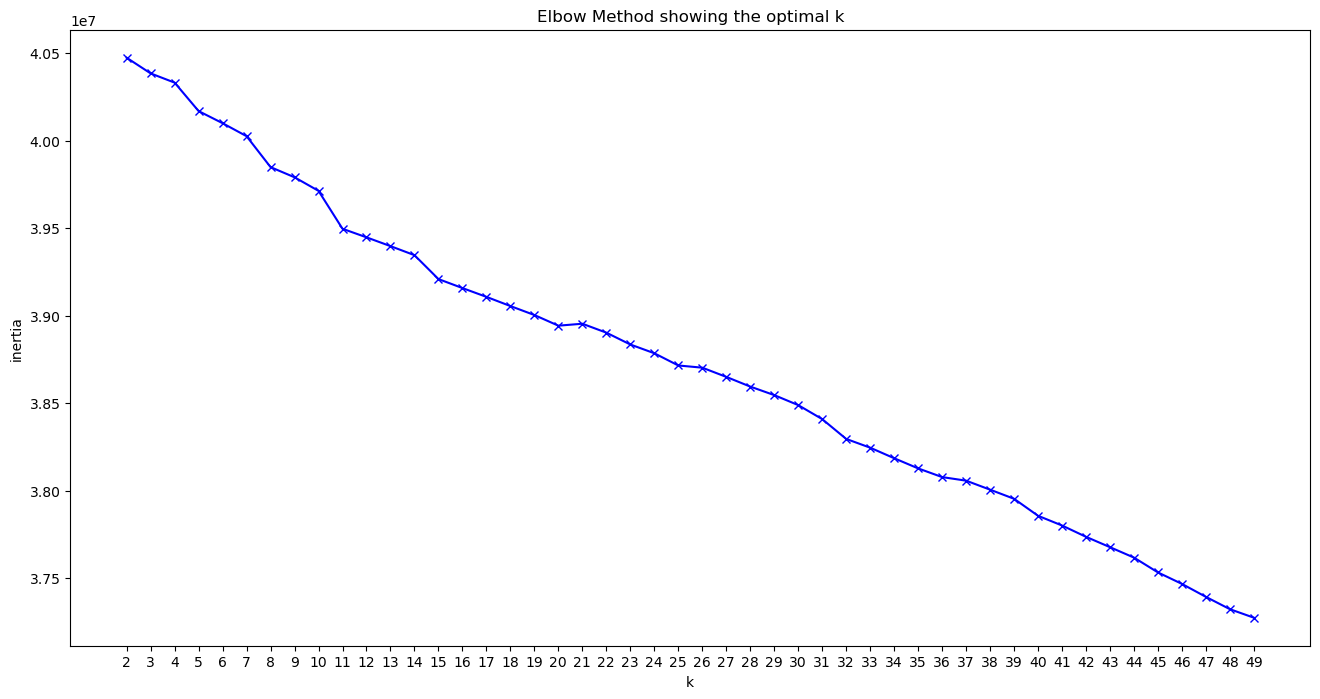

In [28]:
# Setting large range of clusters
K = range(2, 50)
inertia = []

for k in K:
    kmeans = KMeans(n_init = 'auto',
                    n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Elbow line trend is quite irregular, but seems that 5, 10 or 20 k.

- Silohuette method

Text(0.5, 1.0, 'Silhouette score showing the optimal k')

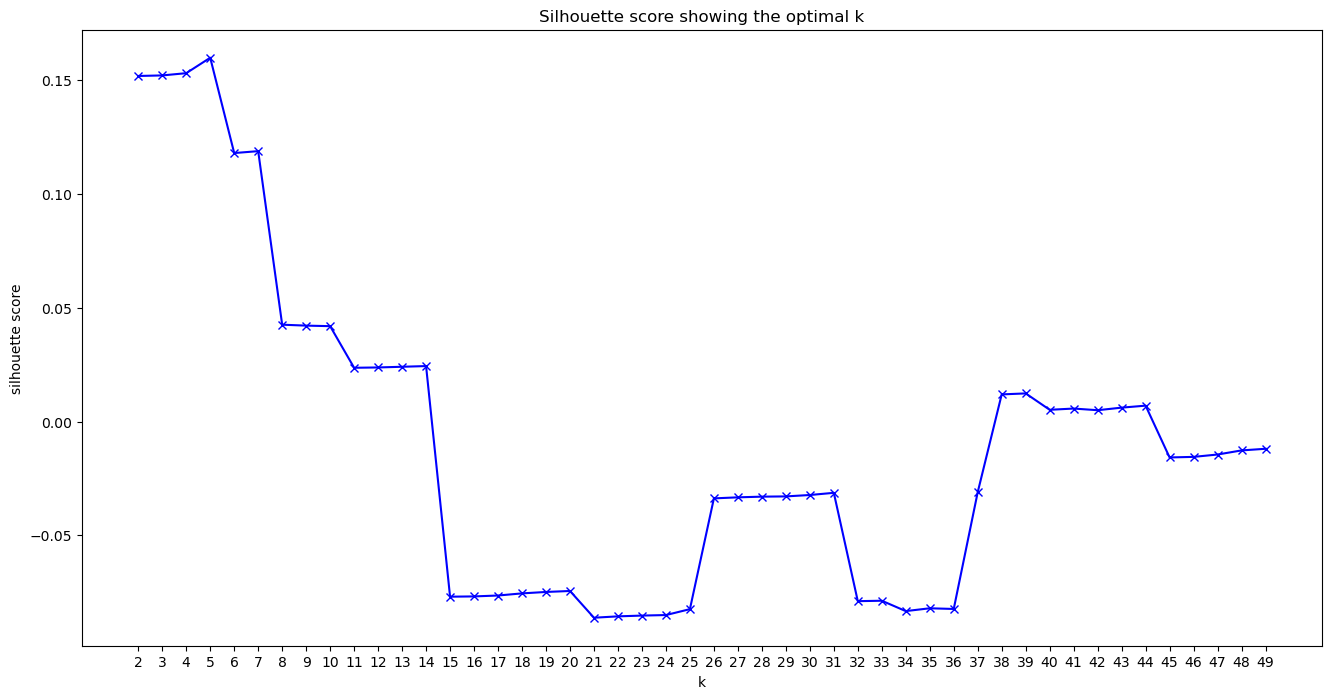

In [99]:
from sklearn.metrics import silhouette_score

K = range(2, 50)
silhouette = []

for k in K:
    kmeans = KMeans(n_init='auto', n_clusters=k, random_state=1234)
    kmeans.fit(X_prep)
    #silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep), n_jobs=1))



plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette score showing the optimal k')

Silhouette suggests K = 5, but distribution of data:

In [7]:
kmeans = KMeans(n_init= 'auto', n_clusters=5, random_state=1234)
kmeans.fit(X_prep)
clusters = kmeans.predict(X_prep)
pd.Series(clusters).value_counts().sort_index()


0    47901
1      154
2        2
3       70
4      413
dtype: int64

But 98,68% of data would be concentrated in 1 cluster.

In [8]:
X_prep.shape

(48540, 854)

In [9]:
47901/48540

0.9868355995055624

#### Clusters for my book recommender

In [18]:
# Dictionary to store cluster counts
cluster_counts = {}

# Loop over different numbers of clusters
for num_cluster in range(2, 21):
    # Fit KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_cluster, random_state=1234)
    kmeans.fit(X_prep)
    # Predict the clusters
    clusters = kmeans.predict(X_prep)
    # Count the number of points in each cluster
    cluster_counts[num_cluster] = pd.Series(clusters).value_counts().sort_index()

# Concatenate the cluster counts into a single dataframe
clusters_df = pd.concat(cluster_counts, axis=1, sort=False)

# Fill NaN with "No cluster"
clusters_df.fillna("No cluster", inplace=True)

# Transpose dataframe and add a first column with the names of the amount of clusters for each row
clusters_df = pd.concat([pd.Series([f"clusters: {i}" for i in range(0, 21)], name="Number of clusters"), clusters_df.transpose()], axis=1)

# Drop rows 0 and 1 (clusters 0 and 1)
clusters_df.drop([0, 1], inplace=True)

clusters_df


,Number of clusters,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
2,clusters: 2,48386.0,154.0,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,...,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster
3,clusters: 3,48384.0,154.0,2.0,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,...,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster
4,clusters: 4,48314.0,154.0,2.0,70.0,No cluster,No cluster,No cluster,No cluster,No cluster,...,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster
5,clusters: 5,47901.0,154.0,2.0,70.0,413.0,No cluster,No cluster,No cluster,No cluster,...,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster
6,clusters: 6,47788.0,154.0,2.0,70.0,413.0,113.0,No cluster,No cluster,No cluster,...,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster
7,clusters: 7,47753.0,154.0,2.0,70.0,413.0,113.0,35.0,No cluster,No cluster,...,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster
8,clusters: 8,408.0,154.0,162.0,71.0,39.0,12515.0,277.0,34914.0,No cluster,...,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster
9,clusters: 9,408.0,154.0,162.0,71.0,39.0,12361.0,277.0,34984.0,84.0,...,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster
10,clusters: 10,408.0,154.0,162.0,71.0,39.0,12364.0,277.0,34958.0,84.0,...,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster
11,clusters: 11,497.0,154.0,162.0,71.0,39.0,11797.0,275.0,31420.0,84.0,...,4018.0,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster,No cluster


I have chosen n_clusters = 11 because it allows for 3 larger and distinct groups, which can capture the diversity present in the original data, rather than having just 1 or 2 larger clusters with 98% of data

#### Number of clusters: 11

In [30]:
kmeans = KMeans(n_init= 'auto', n_clusters=11, random_state=1234)
kmeans.fit(X_prep)

KMeans(n_clusters=11, n_init='auto', random_state=1234)

In [31]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_prep)

In [32]:
print("Shape of X_prep:", X_prep.shape)
print("Shape of cluster centers:", kmeans.cluster_centers_.shape)

Shape of X_prep: (48540, 854)
Shape of cluster centers: (11, 854)


In [33]:
# Size of the clusters / Number of songs in each cluster
pd.Series(clusters).value_counts().sort_index()

0       497
1       154
2       162
3        71
4        39
5     11797
6       275
7     31420
8        84
9        23
10     4018
dtype: int64

In [34]:
#y.values
#pd.Series(y).value_counts().sort_index()

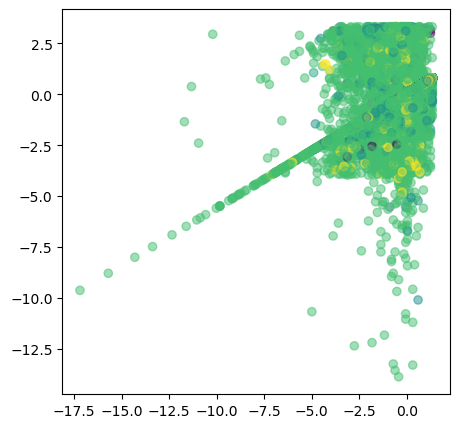

In [35]:
# Plotting (num clusters = 11)
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 1], c=clusters,alpha=0.5)

plt.show()

#### Adding corresponding cluster to gr_data

In [36]:
gr_data["cluster"] = pd.Series(clusters, index=gr_data.index)

In [37]:
gr_data[['title','cluster']].head(30)

,title,cluster
0,The Hunger Games,0
1,Harry Potter and the Order of the Phoenix,0
2,To Kill a Mockingbird,0
3,Pride and Prejudice,0
4,Twilight,0
5,The Book Thief,0
6,Animal Farm,0
7,The Chronicles of Narnia,5
8,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,5
9,Gone with the Wind,0


In [40]:
# Checking results
gr_data['cluster'].value_counts().sort_index()

0       497
1       154
2       162
3        71
4        39
5     11797
6       275
7     31420
8        84
9        23
10     4018
Name: cluster, dtype: int64

#### Saving as CSV

For perfomance improvement of the function of the recommender, I'm going to add an extra column with 'title' name's of books normalized before saving the dataframe.

In [44]:
# Create a new column in gr_data with normalized titles
import unidecode

gr_data['normalized_title'] = gr_data['title'].apply(lambda x: unidecode.unidecode(x).lower())

In [45]:
gr_data[['title','normalized_title','cluster']].head()

,title,normalized_title,cluster
0,The Hunger Games,the hunger games,0
1,Harry Potter and the Order of the Phoenix,harry potter and the order of the phoenix,0
2,To Kill a Mockingbird,to kill a mockingbird,0
3,Pride and Prejudice,pride and prejudice,0
4,Twilight,twilight,0


In [47]:
gr_data.to_csv('./2. Clean_df/gr_data_FOR_CLUSTERING.csv')